In [1]:
import tensorflow.compat.v2 as tf
print(tf.__version__)
# 2.1.0

import matplotlib as mpl
import matplotlib.pyplot as plt
import cv2

mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

2.1.0


In [2]:
#MobileNetV2: Inverted Residuals and Linear Bottlenecks
# https://arxiv.org/abs/1801.04381
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')

#Labels in the imagenet data: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

#We are not training any model parameters
pretrained_model.trainable = False

# ImageNet labels
#These map the class integers to the actual class names in the pre-defined models.
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

In [3]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

(512, 640, 3)


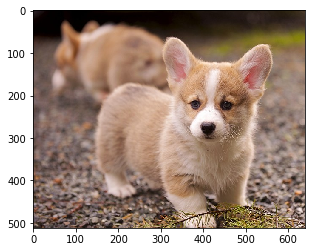

In [5]:
puppy_corgi = cv2.imread('images/puppy_corgi.jpg')
puppy_corgi = cv2.cvtColor(puppy_corgi, cv2.COLOR_BGR2RGB)
plt.imshow(puppy_corgi)

print(puppy_corgi.shape)

In [6]:
image = tf.cast(puppy_corgi, tf.float32)
image = image/255
image = tf.image.resize(image, (224, 224))
image = image[None, ...]
#<tf.Tensor 'strided_slice:0' shape=(1, 224, 224, 3) dtype=float32> # 1 image of size (224, 224, 3)

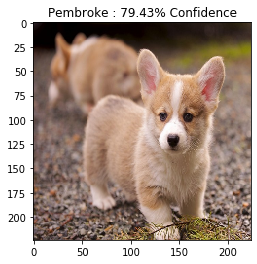

In [9]:
image_probs = pretrained_model.predict(image,steps=1)
#(1, 1000)
prediction = decode_predictions(image_probs, top=1)[0][0]
#('n02113023', 'Pembroke', 0.7949287)

class_probability = decode_predictions(image_probs, top=1)[0][0][2]
#0.7949287

image_class = decode_predictions(image_probs, top=1)[0][0][1]
#'Pembroke'

plt.figure()
plt.imshow(image[0])
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_probability*100))
plt.show()

#this is 263: 'Pembroke, Pembroke Welsh corgi'

# YES! It is Pelmbroke Welsh Corgi with almost 80% confidence!

![](images/pelmbroke_welsh_corgi.png)

# One-shot methods

## Implementing fast gradient sign method (FGSM)

FGSM is a white box untargeted attack. It is white-box because we have complete access to the parameters and the gradients of the model. It is untargeted because we perturb the input image such as to make the model predict any class other than the true class.

ORIGINAL PAPER --> https://arxiv.org/pdf/1412.6572.pdf


https://arxiv.org/pdf/1911.05268.pdf

![](images/FGSM.png)

In [10]:
loss_object = tf.keras.losses.CategoricalCrossentropy() #multi-class classification
#It expects labels to be provided in a one_hot representation.


pembroke_index = 263
label = tf.one_hot(pembroke_index, image_probs.shape[-1])
#<tf.Tensor 'one_hot:0' shape=(1000,) dtype=float32>

label = tf.reshape(label, (1, image_probs.shape[-1]))
#<tf.Tensor 'Reshape:0' shape=(1, 1000) dtype=float32>

#CUSTOM LOOP
with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = pretrained_model(image)
    loss = loss_object(label, prediction) #We calculate the loss of the logits with respect to the true class

# Get the gradients of the loss w.r.t to the input image.
gradient = tape.gradient(loss, image) #We calculate the gradients of the image with respect to the loss.

# Get the sign of the gradients to create the perturbation
signed_grad = tf.sign(gradient)
# The sign function ensures that the magnitude of the loss is maximized

The resulting perturbations can also be visualised.

W0413 17:49:27.280544 4645227968 image.py:693] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


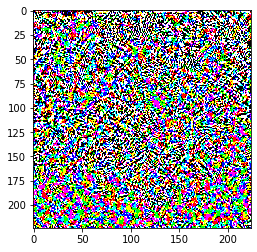

In [11]:
plt.imshow(signed_grad[0])

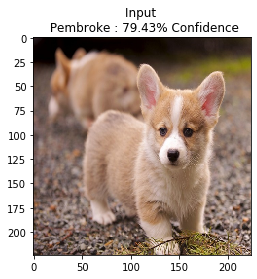

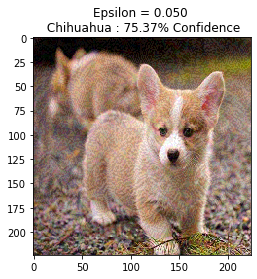

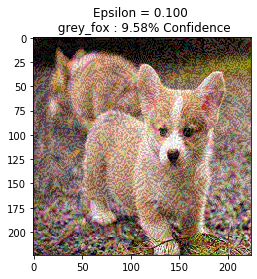

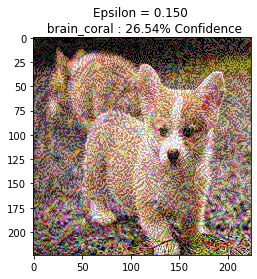

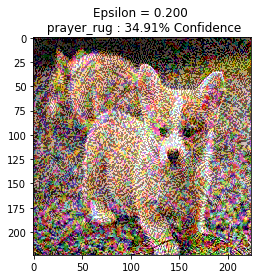

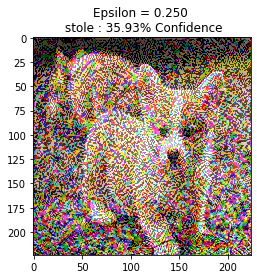

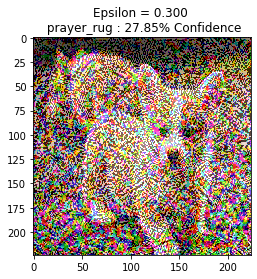

In [12]:
# epsilon is a hyper-parameter to be chose
#different epsilons
#since the image is normalized between 0 and 1, epsilon is between 0 and 1. 
epsilons = [0, .05, .1, .15, .2, .25, .3]

descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    
    # Add perturbations to original image and clip if necessary.
    adv_x = image + eps * signed_grad
    # What happens if we add this gradient on the image?
    # We maximize the loss! This means increasing the loss with respect to the true class. Result: misclassifying the image!
    
    adv_x = tf.clip_by_value(adv_x, 0, 1) #because for an normalized image pixels should be between 0 and 1.
    
    image_probs = pretrained_model.predict(adv_x,steps=1)
    
    prediction = decode_predictions(image_probs, top=1)[0][0]

    class_probability = decode_predictions(image_probs, top=1)[0][0][2]
    
    image_class = decode_predictions(image_probs, top=1)[0][0][1]
    
    plt.figure()
    plt.imshow(adv_x[0])
    plt.title('{} \n {} : {:.2f}% Confidence'.format(descriptions[i], image_class, class_probability*100))
    plt.show()

# you see how the confidence in predictions vary as you change epsilon!